# Deep learning and AI methods
## Session 5: Analyzing image data using convolution neural networks
* Instructor: [Krzysztof Podgorski](https://krys.neocities.org),  [Statistics, Lund University, LUSEM](https://www.stat.lu.se/)
* For more information visit the [CANVAS class website](https://canvas.education.lu.se/courses/1712).

In this session you are ask to run the following Notebook in which convolution neural networks are used to analyse previously studied data set.

### Main Task:

Run the following code. Then explore on your own differented features of the presented tools. At the end of the notebook summarize what did you explore and draw some conclusions from your finding. This summary should not be longer than one page equivalent of a regular text. 

# Image Classification with Convolutional Neural Networks

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [6]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /Users/mats-ksp/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Check if the data are there

Let's plot an image to see what it looks like.

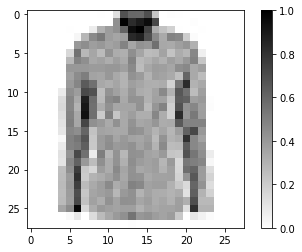

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network layers are:

* **"convolutions"** `tf.keras.layers.Conv2D and MaxPooling2D`— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

* **output** `tf.keras.layers.Dense` — A 128-neuron, followed by 10-node *softmax* layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [14]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.3899 - accuracy: 0.8587
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2575 - accuracy: 0.9060
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2121 - accuracy: 0.9234
Epoch 4/10
1875/1875 [==============================] - 25s 14ms/step - loss: 0.1824 - accuracy: 0.9323
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1516 - accuracy: 0.9435
Epoch 6/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1302 - accuracy: 0.9527
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1116 - accuracy: 0.9591
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0926 - accuracy: 0.9661
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0783 - accuracy: 0.9710
Epoch 10/10
1875/1875 [==============================] - 27s 15m

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.97 (or 97%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.3033 - accuracy: 0.9190
Accuracy on test dataset: 0.919


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Task 1:

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10, activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

 Adjusting the epochs value for the CNN

I create a new model with the same model architecture as above, as otherwise Python will remember the training. Thus, one could not get a proper insight on how adjusting the epochs value will affect the model performance.

In [18]:
model_alt = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model_alt.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Task 2:

Experiment with at least two more models that involve the convolution in one layer. Make the fit of your models and compare the accuracy betweem the model. Make predictions and explore the models. Illustrate your findings and comment. Comapare with the results to other methods explored in the previous labs on this data set. DO NOT experiment with cross-validation as it can be computationally too expensive for the convolution considered models. 

Adjusting the architecture of the CNN

In [22]:
#Set up different model architectures of the CNN
#Model 2: 50 Units in the hidden layer

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Adding additional dense layers

In [29]:
#I play with different layers of a TOTAL of 128 hidden units
#Model A is just the same as the first default model as specified already above, i.e. 1 hidden layer
modelA = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
modelA.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



Unnormalized pixel values

In [0]:
#Download the data again, but this time storing it as dataset2
dataset2, metadata2 = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset2, test_dataset2 = dataset2['train'], dataset2['test']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [0]:
num_train_examples2 = metadata2.splits['train'].num_examples
num_test_examples2 = metadata2.splits['test'].num_examples
print("Number of training examples in dataset2: {}".format(num_train_examples2))
print("Number of test examples in dataset2:     {}".format(num_test_examples2))

For comparison reasons, I just train the unnormalized dataset with the very first model with 128 hidden units and one hidden layer.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Task 3: 

Use the reduced data set with 4 x 4 pixels and check the performance of your preferred convolution neural network on the reduced data set. Compare with all the previous results and comment. 

## Grader box: 

In what follows the grader will put the values according the following check list:

* 1 Have all commands included in a raw notebook been evaluated? (0 or 0.5pt)
* 2 Have all commands been experimented with? (0 or 0.5pt)
* 3 Have all experiments been briefly commented? (0 or 0.5pt)
* 4 Have all tasks been attempted? (0, 0.5, or 1pt)
* 5 How many of the tasks have been completed? (0, 0.5, or 1pt)
* 6 How many of the tasks (completed or not) have been commented? (0, 0.5, or 1pt)
* 7 Have been the conclusions from performing the tasks clearly stated? (0, 0.5, or 1pt)
* 8 Have been the overall organization of the submitted Lab notebook been neat and easy to follow by the grader? (0, or 0.5pt) 


#### 1 Have all commands included in a raw notebook been evaluated? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A
#### Grader's comment (if desired): 
N/A

#### 2 Have all commands been experimented with? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A

#### 3 Have all experiments been briefly commented? (0 or 0.5pt)

#### Grader's comment (if desired): 
N/A

#### 4 Have all tasks been attempted? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 5 How many of the tasks have been completed? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 6 How many of the tasks (completed or not) have been commented? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 7 Have been the conclusions from performing the tasks clearly stated? (0, 0.5, or 1pt)

#### Grader's comment (if desired): 
N/A

#### 8 Have been the overall organization of the submitted Lab notebook been neat and easy to follow by the grader? (0, or 0.5pt)

#### Grader's comment (if desired): 
N/A

### Overall score

### Score and grader's comment (if desired): 
N/A